In [1]:
import importlib
import arbol
importlib.reload(arbol)
from arbol import *
import numpy as np
import random

In [2]:
nroot = GPTree('add', 
    left=GPTree('mul',
        left=GPTree(3),
        right=GPTree('x')), 
    right=GPTree('inv', 
        left=GPTree(0.5)))
nroot2 = GPTree('mul',
        left=GPTree(3),
        right=GPTree('x')) 
    

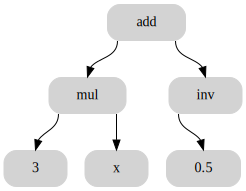

In [3]:
nroot.graphviz()

In [55]:
from sys import getsizeof
treelist = [nroot, nroot] # para probar, lista de trees con mismo size
print(getsizeof(nroot)) # este arbol ocupa 48 bytes

arr = np.array([nroot, nroot], dtype=object) # si lo hacemos como se haria normalmente sale mal
print('Np.array mal:')
print(arr) # coge cada arbol como lista de nodos y lo estira fila a fila
print(arr.shape, arr.size) # 2 dimensional, muchos mas elementos
print(arr.itemsize, arr.nbytes) # como guarda punteros cada el. son 8 bytes, pero guarda mas
print(getsizeof(arr)) # la np.array acaba ocupando mucho mas

arr2 = np.ndarray(2, dtype=GPTree) # asi lo creamos vacio
arr2[:] = treelist # y luego lo llenamos
print('Np.array creando vacia y luego asignando:')
print(arr2) 
print(arr2.shape, arr2.size) # dimensiones y num de elementos bien, las dos raices
print(arr2.itemsize, arr2.nbytes) # el tam por item es el mismo al ser punteros, pero solo cogiendo raices
print(getsizeof(arr2)) # ocupa en total mucho menos espacio

arr3 = np.fromiter(treelist, dtype=GPTree) # o podemos hacer esto y ya esta, 1 linea easy
print('Np.array tomando de iterador (lista)')
print(arr3) # todo esto igual que el de arriba
print(arr3.shape, arr3.size)
print(arr3.itemsize, arr3.nbytes) 
print(getsizeof(arr3))

48
Np.array mal:
[[Node(add) Node(mul) Node(inv) Node(3) Node(x) Node(0.5)]
 [Node(add) Node(mul) Node(inv) Node(3) Node(x) Node(0.5)]]
(2, 6) 12
8 96
224
Np.array creando vacia y luego asignando:
[Node(add) Node(add)]
(2,) 2
8 16
128
Np.array tomando de iterador (lista)
[Node(add) Node(add)]
(2,) 2
8 16
128


In [59]:
def softcast(P):
	pop_casted=np.empty(len(P),dtype=object)
	pop_casted[:]=P[:]

In [60]:
import time
P = [nroot]*100
N = 100000
time_2_start = time.time()
for i in range(N):
    arr2 = softcast(P)
time_2_end = time.time()
print((time_2_end-time_2_start)/N)

time_3_start = time.time()
for i in range(N):
    arr3 = np.fromiter(P, dtype=GPTree)
time_3_end = time.time()
print((time_3_end-time_3_start)/N)

0.00037735749244689943
5.722572803497315e-06


In [4]:
def mae(y, y_pred, w=None):
    return np.average(np.abs(y-y_pred), weights=w)

def mse(y, y_pred, w=None):
    return np.average(np.power(y-y_pred,2), weights=w)

def rmse(y, y_pred, w=None):
    return np.sqrt(mse(y, y_pred, w=w))

In [4]:
def target_func(x): # evolution's target
    return x*x*x*x + x*x*x + x*x + x + 1

def generate_dataset(): # generate 101 data points from target_func
    x_list, y_list = [], []
    for x in range(-100,101,2): 
        x /= 100
        x_list.append(x)
        y_list.append(target_func(x))
    return np.array(x_list), np.array(y_list)

x, y = generate_dataset()

In [ ]:
trees = np.array([nroot, nroot2], dtype=object)
ERROR_FUNC = rmse
FIT_ADJUST_SIZE=0.0

def eval_fitness(tree, x, y, w=None):
    y_pred = tree.calculate_recursive(x)
    return ERROR_FUNC(y,y_pred,w=w)*(1+FIT_ADJUST_SIZE*tree.size)

eval_fitness_vec=np.vectorize(eval_fitness, excluded=['x','y','w'])
eval_fitness_vec(trees,x=x,y=y)

array([1.10206036, 1.84573786])

In [22]:
MAX_DEPTH=3
MIN_DEPTH=2
PROB_SYMBOL=0.5

def random_terminal():
	if random.random()<PROB_SYMBOL:
		return SYMBOL
	else:
		return 5*random.random()
		
def gen_tree(depth=0):
	if depth<MIN_DEPTH:
		if depth==0:
			n1 = GPTree(random.choice(FUNC_AR2_LIST))
		else:
			n1 = GPTree(random.choice(FUNC_LIST))
	elif depth>=MAX_DEPTH:
		n1 = GPTree(random_terminal())
	else:
		if random.random()<0.5:
			n1 = GPTree(random.choice(FUNC_LIST))
		else:
			n1 = GPTree(random_terminal())
	if n1.is_func():
		n1.left=gen_tree(depth+1)
		if n1.arity()==2:
			n1.right=gen_tree(depth+1)
	return n1		
n1, n2 = gen_tree(), gen_tree()
n1.pprint()
n2.pprint()


                       _________________________add________________________
                      /                                                    \
                   _mul_____________________                              _add____________________
                  /                         \                            /                        \
         _______inv                _________inv               _________inv               _________mul
        /                         /                          /                          /            \
3.2510915228502         0.11328550004494287         3.5055644120404454         0.7421924941812785     x


                            ___________________sub__________________________________________
                           /                                                                \
                      ___add________                                    ____________________inv
                     /              \                

In [51]:
def crossover(tree1,tree2):
	node1=np.random.choice(tree1.preorder[1:])
	node2=np.random.choice(tree2.preorder[1:])
	
	node1.val,node2.val=node2.val,node1.val
	node1.right,node2.right=node2.right,node1.right
	node1.left,node2.left=node2.left,node1.left
	return tree1,tree2
n1_x, n2_x = crossover(n1, n2)
n1_x.pprint()
n2_x.pprint()


          _________add__________________________________________________
         /                                                              \
0.7421924941812785                                                     _add______________________________________________________________________________
                                                                      /                                                                                  \
                                                                   _inv                            ______________________________________________________add________
                                                                  /                               /                                                                 \
                                            ____________________inv                            _sub________________________________________________          0.450276073260939
                                     